# Defining Fault Sampling Approaches in fmdtools

Fault Sampling is used to evaluate the overall resilience of a system to a set of faults and the corresponding risks associated with these faults. There is no single best way to define the set of scenarios to evaluate resilience with, because a given resilience analysis may need more or less detail, support more or less computational time, or be interested in specific scenario types of interest.

Thus, there are a number of use-cases supported by fmdtools for different sampling models. This document will demonstrate and showcase a few of them.

```
Copyright © 2024, United States Government, as represented by the Administrator of the National Aeronautics and Space Administration. All rights reserved.

The “"Fault Model Design tools - fmdtools version 2"” software is licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0. 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
```


In [1]:
from fmdtools.sim.sample import SampleApproach, FaultSample, FaultDomain
from fmdtools.analyze.tabulate import FMEA, Comparison
import fmdtools.sim.propagate as prop
import numpy as np

### Basics

Fault sampling involves:
- Defining faults and fault models for each function/component/flows of the model is done using the 'Mode' Class
- Defining a fault sampling approach, using the: 
    - `SampleApproach` class, or
    -  `FaultDomain` and `FaultSample` calsses directly
- Propagating faults through the model (using the `propagate.faultsample` method)
Before proceeding, it can be helpful to look through their respective documentation.

### Model Setup

Consider the rover model in `rover_model`

In [2]:
import inspect
from rover_model import Power, PowerMode

This rover has a Power function:

In [3]:
print(inspect.getsource(Power))

class Power(Function):
    """Rover power supply."""

    __slots__ = ("ee_15", "ee_5", "ee_12", "switch")
    container_s = PowerState
    container_m = PowerMode
    flow_ee_15 = EE
    flow_ee_5 = EE
    flow_ee_12 = EE
    flow_switch = Switch

    def static_behavior(self, time):
        """Determine power use based on mode."""
        if self.m.in_mode("off"):
            self.off_power()
        elif self.m.in_mode("supply"):
            self.supply_power()
        elif self.m.in_mode("short"):
            self.short_power()
        elif self.m.in_mode("no_charge"):
            self.no_charge_power()

        if self.m.in_mode("charge"):
            self.charge_power_usage()
        else:
            self.power_usage()
            if self.m.in_mode("short"):
                self.short_power_usage()

    def dynamic_behavior(self, time):
        """Charge increment over time."""
        self.s.inc(charge=-self.s.power / 100)
        self.s.limit(charge=(0, 100))

    def short_po

Which contains the mode `PowerMode`:

In [4]:
print(inspect.getsource(PowerMode))

class PowerMode(Mode):
    """
    Possible modes for Power function.

    Modes
    -------
    no_charge : Fault
        Battery is out of charge.
    short: Fault
        There is a short.
    supply: Mode
        supply power
    charge: Mode
        charge battery
    standby: Mode
        power supply is in stand by
    off: Mode
        power supply is off
    """

    fault_no_charge = (1e-5, 100, (("off", 1.0),))
    fault_short = (1e-5, 100, (("supply", 1.0),))
    opermodes = ("supply", "charge", "off")
    mode: str = "off"
    exclusive = True



The class variable `fm_args` specifies that there are two possible modes to inject, "no_charge", and "shortn", with no more information given for each mode. More information has been added in the tuples of the dictionary, including:
- rate
- repair cost
- phase dictionary
The phase dictionary is important because it specifies that this mode is to occur in a given phase. In this case, `no_charge` is supposed to only occur during the `standby` phase while `short` is only supposed to occur during the `supply` phase. In this `Mode`, these phases correspond to the operational modes (`opermodes`), but they may correspond to other operational modes also.

All of these fields are optional, but they do help us develop a more informed statistical sample of the fault modes.

### Setting up a FaultSample

Sampling using `FaultSample` first requires creating a `FaultDomain` to sample from. These faultdomains can be created from both models and individual functions:

In [5]:
fd_power = FaultDomain(Power())
fd_power.add_all()
fd_power

FaultDomain with faults:
 -('power', 'no_charge')
 -('power', 'short')

In [6]:
from rover_model import Rover
fd_rvr = FaultDomain(Rover())
fd_rvr.add_all()
fd_rvr

FaultDomain with faults:
 -('rover.fxns.power', 'no_charge')
 -('rover.fxns.power', 'short')
 -('rover.fxns.perception', 'bad_feed')
 -('rover.fxns.plan_path', 'crash')
 -('rover.fxns.plan_path', 'no_con')
 -('rover.fxns.drive', 'hmode_0')
 -('rover.fxns.drive', 'hmode_1')
 -('rover.fxns.drive', 'hmode_2')
 -('rover.fxns.drive', 'hmode_3')
 -('rover.fxns.drive', 'hmode_4')
 -...more

Note that there are several methods in FaultDomain which let us specify the list of faults we want to sample from, e.g.:

In [7]:
fd_short = FaultDomain(Rover())
fd_short.add_all_modes("short")
fd_short

FaultDomain with faults:
 -('rover.fxns.power', 'short')

or:

In [8]:
fd_pwr = FaultDomain(Rover())
fd_pwr.add_all_fxn_modes("power")
fd_pwr

FaultDomain with faults:
 -('rover.fxns.power', 'no_charge')
 -('rover.fxns.power', 'short')

We can then sample this domain using a `FaultSample`:

In [9]:
fs_pwr = FaultSample(fd_pwr, def_mdl_phasemap=False)

Note that FaultSamples have two main variables: faultdomain and phasemap. A PhaseMap is essentially a dictionary of phases to sample from.

In the above case, we don't want to use phase information to form the sample, so we don't provide any and we set `def_mdl_phasemap=False`, since this would get phase information from the model.

To add scenarios to the `FaultSample`, we can then use one of the `add` methods:

In [10]:
fs_pwr.add_fault_times([2,5,10])
fs_pwr

FaultSample of scenarios: 
 - rover_fxns_power_no_charge_t2
 - rover_fxns_power_no_charge_t5
 - rover_fxns_power_no_charge_t10
 - rover_fxns_power_short_t2
 - rover_fxns_power_short_t5
 - rover_fxns_power_short_t10

As shown, this adds the list of faults in the faultdomain over the given times.

Note the underlying rate information in these scenarios is all the same:

In [11]:
fs_pwr.scenarios()

[SingleFaultScenario(sequence={2.0: Injection(faults={'rover.fxns.power': ['no_charge']}, disturbances={})}, times=(2,), function='rover.fxns.power', fault='no_charge', rate=1e-05, name='rover_fxns_power_no_charge_t2', time=2, phase=''),
 SingleFaultScenario(sequence={5.0: Injection(faults={'rover.fxns.power': ['no_charge']}, disturbances={})}, times=(5,), function='rover.fxns.power', fault='no_charge', rate=1e-05, name='rover_fxns_power_no_charge_t5', time=5, phase=''),
 SingleFaultScenario(sequence={10.0: Injection(faults={'rover.fxns.power': ['no_charge']}, disturbances={})}, times=(10,), function='rover.fxns.power', fault='no_charge', rate=1e-05, name='rover_fxns_power_no_charge_t10', time=10, phase=''),
 SingleFaultScenario(sequence={2.0: Injection(faults={'rover.fxns.power': ['short']}, disturbances={})}, times=(2,), function='rover.fxns.power', fault='short', rate=1e-05, name='rover_fxns_power_short_t2', time=2, phase=''),
 SingleFaultScenario(sequence={5.0: Injection(faults={'r

But we know better than this--some of the faults should have zero rate if they are going to occur in phases they don't apply to!

If we want to sample the given phases for the sample, we can additionally pass a phasemap generated by first running the model in the nominal state:

In [12]:
res, hist = prop.nominal(Rover())

We can then get phase information from this history using the `fmdtools.analyze.phases.from_hist`:

In [13]:
from fmdtools.analyze.phases import from_hist, phaseplot
phases = from_hist(hist)
phases

{'power': PhaseMap({'off': [0.0, 0.0], 'supply': [1.0, 112.0]}, {'off': {'off'}, 'supply': {'supply'}}),
 'perception': PhaseMap({'off': [0.0, 1.0], 'feed': [2.0, 112.0]}, {'off': {'off'}, 'feed': {'feed'}}),
 'plan_path': PhaseMap({'standby': [0.0, 4.0], 'drive': [5.0, 112.0]}, {'standby': {'standby'}, 'drive': {'drive'}}),
 'override': PhaseMap({'off': [0.0, 1.0], 'standby': [2.0, 112.0]}, {'off': {'off'}, 'standby': {'standby'}})}

Which can be visualized using:

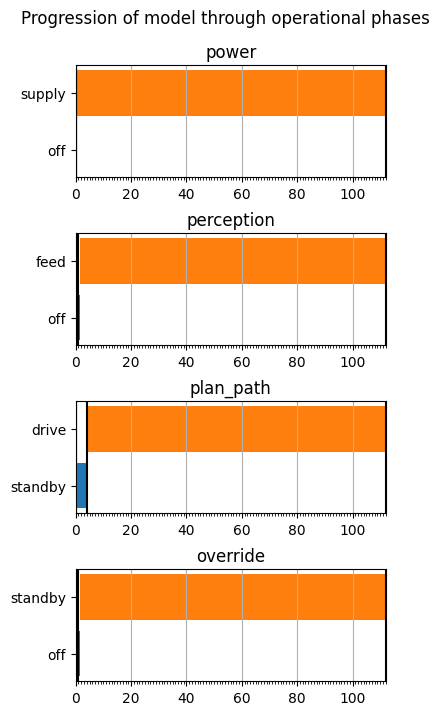

In [14]:
fig = phaseplot(phases)

The `PhaseMap` for `Power` is here in `power`:

In [15]:
phases['power']

PhaseMap({'off': [0.0, 0.0], 'supply': [1.0, 112.0]}, {'off': {'off'}, 'supply': {'supply'}})

Which we can use to create a `FaultSample` which only samples the phases corresponding to the information given in `Mode`:

In [16]:
fs_pwr = FaultSample(fd_pwr, phasemap=phases['power'])
fs_pwr.add_fault_phases()
fs_pwr

FaultSample of scenarios: 
 - rover_fxns_power_no_charge_t0p0
 - rover_fxns_power_short_t0p0
 - rover_fxns_power_no_charge_t56p0
 - rover_fxns_power_short_t56p0

If we look at the rate information, however:

In [17]:
fs_pwr.scenarios()

[SingleFaultScenario(sequence={0.0: Injection(faults={'rover.fxns.power': ['no_charge']}, disturbances={})}, times=(0.0,), function='rover.fxns.power', fault='no_charge', rate=1e-05, name='rover_fxns_power_no_charge_t0p0', time=0.0, phase='off'),
 SingleFaultScenario(sequence={0.0: Injection(faults={'rover.fxns.power': ['short']}, disturbances={})}, times=(0.0,), function='rover.fxns.power', fault='short', rate=0.0, name='rover_fxns_power_short_t0p0', time=0.0, phase='off'),
 SingleFaultScenario(sequence={56.0: Injection(faults={'rover.fxns.power': ['no_charge']}, disturbances={})}, times=(56.0,), function='rover.fxns.power', fault='no_charge', rate=0.0, name='rover_fxns_power_no_charge_t56p0', time=56.0, phase='supply'),
 SingleFaultScenario(sequence={56.0: Injection(faults={'rover.fxns.power': ['short']}, disturbances={})}, times=(56.0,), function='rover.fxns.power', fault='short', rate=1e-05, name='rover_fxns_power_short_t56p0', time=56.0, phase='supply')]

The rate for scenarios outside the phases is zero!

We can remove these scenarios using `FaultSample.prune_scenarios`:

In [18]:
fs_pwr.prune_scenarios("rate", np.greater, 0.0)
fs_pwr

FaultSample of scenarios: 
 - rover_fxns_power_no_charge_t0p0
 - rover_fxns_power_short_t56p0

In [19]:
fs_pwr.scenarios()

[SingleFaultScenario(sequence={0.0: Injection(faults={'rover.fxns.power': ['no_charge']}, disturbances={})}, times=(0.0,), function='rover.fxns.power', fault='no_charge', rate=1e-05, name='rover_fxns_power_no_charge_t0p0', time=0.0, phase='off'),
 SingleFaultScenario(sequence={56.0: Injection(faults={'rover.fxns.power': ['short']}, disturbances={})}, times=(56.0,), function='rover.fxns.power', fault='short', rate=1e-05, name='rover_fxns_power_short_t56p0', time=56.0, phase='supply')]

As shown, now the only scenarios in the `FaultSample` are ones which have nonzero rate.

In [20]:
assert all([scen.rate > 0 for scen in fs_pwr.scenarios()])

To enable multiple samples to be generated for different faultdomains accross the model, we can use `SampleApproach`, e.g.:

In [21]:
phases

{'power': PhaseMap({'off': [0.0, 0.0], 'supply': [1.0, 112.0]}, {'off': {'off'}, 'supply': {'supply'}}),
 'perception': PhaseMap({'off': [0.0, 1.0], 'feed': [2.0, 112.0]}, {'off': {'off'}, 'feed': {'feed'}}),
 'plan_path': PhaseMap({'standby': [0.0, 4.0], 'drive': [5.0, 112.0]}, {'standby': {'standby'}, 'drive': {'drive'}}),
 'override': PhaseMap({'off': [0.0, 1.0], 'standby': [2.0, 112.0]}, {'off': {'off'}, 'standby': {'standby'}})}

In [22]:
sa = SampleApproach(Rover(), phasemaps=phases)
# adding fault domains
sa.add_faultdomain("drive", "fault", "drive", "hmode_1")
sa.add_faultdomain("plan_path", "all_fxn_modes", "plan_path")
sa.add_faultdomain("power", "all_fxn_modes", "power")
sa.add_faultsample("drive", "fault_phases", "drive", phasemap="plan_path")
sa.add_faultsample("plan_path", "fault_phases", "plan_path", phasemap="plan_path")
sa.add_faultsample("power", "fault_phases", "power", phasemap="power")
sa.prune_scenarios()

In [23]:
sa

SampleApproach for rover with: 
 faultdomains: drive, plan_path, power
 faultsamples: drive, plan_path, power

In [24]:
sa.scenarios()

[SingleFaultScenario(sequence={58.0: Injection(faults={'drive': ['hmode_1']}, disturbances={})}, times=(58.0,), function='drive', fault='hmode_1', rate=0.027777777777777776, name='drive_hmode_1_t58p0', time=58.0, phase='drive'),
 SingleFaultScenario(sequence={2.0: Injection(faults={'rover.fxns.plan_path': ['crash']}, disturbances={})}, times=(2.0,), function='rover.fxns.plan_path', fault='crash', rate=0.0001, name='rover_fxns_plan_path_crash_t2p0', time=2.0, phase='standby'),
 SingleFaultScenario(sequence={2.0: Injection(faults={'rover.fxns.plan_path': ['no_con']}, disturbances={})}, times=(2.0,), function='rover.fxns.plan_path', fault='no_con', rate=0.0001, name='rover_fxns_plan_path_no_con_t2p0', time=2.0, phase='standby'),
 SingleFaultScenario(sequence={58.0: Injection(faults={'rover.fxns.plan_path': ['crash']}, disturbances={})}, times=(58.0,), function='rover.fxns.plan_path', fault='crash', rate=0.0001, name='rover_fxns_plan_path_crash_t58p0', time=58.0, phase='drive'),
 SingleFau

This is mostly useful when we would like to sample different functions in a model differently than others (e.g., using different phases), but still want to propagate the scenarios together as a part of a single sample.

### Propagating Faults

Given the `FaultSample` approach, faults can then be propagated through the model to get results. Note that these faults can be sampled in parallel if desired using a user-provided pool (see the parallel pool tutorial in the `\pump example` folder).

In [25]:
res, hist = prop.fault_sample(Rover(), fs_pwr)

SCENARIOS COMPLETE: 100%|██████████| 2/2 [00:00<00:00, 14.28it/s]


In [26]:
fs_pwr.scenarios()

[SingleFaultScenario(sequence={0.0: Injection(faults={'rover.fxns.power': ['no_charge']}, disturbances={})}, times=(0.0,), function='rover.fxns.power', fault='no_charge', rate=1e-05, name='rover_fxns_power_no_charge_t0p0', time=0.0, phase='off'),
 SingleFaultScenario(sequence={56.0: Injection(faults={'rover.fxns.power': ['short']}, disturbances={})}, times=(56.0,), function='rover.fxns.power', fault='short', rate=1e-05, name='rover_fxns_power_short_t56p0', time=56.0, phase='supply')]

In [27]:
hist.rover_fxns_power_short_t56p0.flows.pos.s.x

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.26228971,  0.49976748,  0.75073622,  1.02156689,  1.32129469,
        1.64872275,  1.97931323,  2.28554745,  2.5617033 ,  2.81293761,
        3.05023699,  3.27790299,  3.50955358,  3.74782502,  4.00173726,
        4.27958216,  4.58909344,  4.92131254,  5.24511574,  5.53944945,
        5.80388536,  6.04976253,  6.28347644,  6.51647431,  6.75159711,
        6.99704083,  7.26107844,  7.55319773,  7.87591486,  8.20846606,
        8.51950465,  8.79935905,  9.05524795,  9.29420557,  9.52437137,
        9.75690271,  9.99541657, 10.24718399, 10.5213614 , 10.82691482,
       11.15775968, 11.48436846, 11.78261477, 12.05194732, 12.29896633,
       12.53412411, 12.76759447, 13.00158045, 13.24371735, 13.50429217,
       13.79153424, 14.11009375, 14.4433811 , 14.75940856, 15.04465136,
       15.30237525, 15.54407263, 15.7756063 , 16.00796687, 16.24490728,
       16.49506726, 16.76634091, 17.06780748, 17.39659755, 17.72

In [28]:
hist.rover_fxns_power_short_t56p0.fxns.power.s.charge

array([100.   ,  99.99 ,  99.98 ,  99.8  ,  99.62 ,  99.44 ,  99.235,
        99.03 ,  98.825,  98.62 ,  98.415,  98.21 ,  98.005,  97.8  ,
        97.595,  97.39 ,  97.185,  96.98 ,  96.775,  96.57 ,  96.365,
        96.16 ,  95.955,  95.75 ,  95.545,  95.34 ,  95.135,  94.93 ,
        94.725,  94.52 ,  94.315,  94.11 ,  93.905,  93.7  ,  93.495,
        93.29 ,  93.085,  92.88 ,  92.675,  92.47 ,  92.265,  92.06 ,
        91.855,  91.65 ,  91.445,  91.24 ,  91.035,  90.83 ,  90.625,
        90.42 ,  90.215,  90.01 ,  89.805,  89.6  ,  89.395,  89.19 ,
        88.985,  86.935,  84.885,  82.835,  80.785,  78.735,  76.685,
        74.635,  72.585,  70.535,  68.485,  66.435,  64.385,  62.335,
        60.285,  58.235,  56.185,  54.135,  52.085,  50.035,  47.985,
        45.935,  43.885,  41.835,  39.785,  37.735,  35.685,  33.635,
        31.585,  29.535,  27.485,  25.435,  23.385,  21.335,  19.285,
        17.235,  15.185,  13.135,  11.085,   9.035,   6.985,   4.935,
         2.885,   0.

In [29]:
hist.rover_fxns_power_short_t56p0.fxns.power.s.charge

array([100.   ,  99.99 ,  99.98 ,  99.8  ,  99.62 ,  99.44 ,  99.235,
        99.03 ,  98.825,  98.62 ,  98.415,  98.21 ,  98.005,  97.8  ,
        97.595,  97.39 ,  97.185,  96.98 ,  96.775,  96.57 ,  96.365,
        96.16 ,  95.955,  95.75 ,  95.545,  95.34 ,  95.135,  94.93 ,
        94.725,  94.52 ,  94.315,  94.11 ,  93.905,  93.7  ,  93.495,
        93.29 ,  93.085,  92.88 ,  92.675,  92.47 ,  92.265,  92.06 ,
        91.855,  91.65 ,  91.445,  91.24 ,  91.035,  90.83 ,  90.625,
        90.42 ,  90.215,  90.01 ,  89.805,  89.6  ,  89.395,  89.19 ,
        88.985,  86.935,  84.885,  82.835,  80.785,  78.735,  76.685,
        74.635,  72.585,  70.535,  68.485,  66.435,  64.385,  62.335,
        60.285,  58.235,  56.185,  54.135,  52.085,  50.035,  47.985,
        45.935,  43.885,  41.835,  39.785,  37.735,  35.685,  33.635,
        31.585,  29.535,  27.485,  25.435,  23.385,  21.335,  19.285,
        17.235,  15.185,  13.135,  11.085,   9.035,   6.985,   4.935,
         2.885,   0.

In [30]:
res

rover_fxns_power_no_               1e-05
rover_fxns_power_no_                   0
rover_fxns_power_no_                 1.0
rover_fxns_power_no_                   0
rover_fxns_power_no_                True
rover_fxns_power_no_               False
rover_fxns_power_no_                   1
rover_fxns_power_no_                   1
rover_fxns_power_no_   28.91724385770989
rover_fxns_power_no_                 0.0
rover_fxns_power_no_            array(1)
rover_fxns_power_no_incomplete mission faulty
rover_fxns_power_no_                 0.0
rover_fxns_power_no_                 0.0
rover_fxns_power_no_            array(2)
rover_fxns_power_sho               1e-05
rover_fxns_power_sho                   0
rover_fxns_power_sho                 1.0
rover_fxns_power_sho                   0
rover_fxns_power_sho                True
rover_fxns_power_sho               False
rover_fxns_power_sho                   1
rover_fxns_power_sho                   1
rover_fxns_power_sho   3.258651134742929
rover_fxns_

These responses can be visualized over the given faults:

In [31]:
fmea = FMEA(res, fs_pwr, metrics = ["end_dist", "line_dist", "tot_deviation"])
fmea.as_table()

average_scenario_rate  sum_cost  expected_cost
rover.fxns.power no_charge                0.00001         0            0.0
                 short                    0.00001         0            0.0

(<Figure size 600x400 with 4 Axes>,
 array([<Axes: title={'center': 'average_scenario_rate'}>,
        <Axes: title={'center': 'sum_cost'}, xlabel="['function', 'fault']">,
        <Axes: title={'center': 'expected_cost'}, xlabel="['function', 'fault']">,
        <Axes: >], dtype=object))

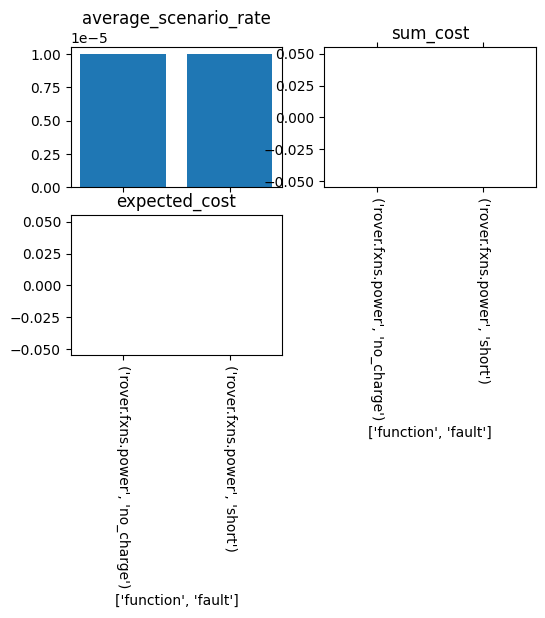

In [32]:
fmea.as_plots(cols=2)

Or over time/any other variable:

In [33]:
comp = Comparison(res, fs_pwr, metrics = ["end_dist", "line_dist", "tot_deviation"], factors =['time'])
comp.as_table()

,end_dist,line_dist,tot_deviation
56.0,3.258651,1.0,0.118596
0.0,28.917244,1.0,0.000000


(<Figure size 600x400 with 4 Axes>,
 array([<Axes: title={'center': 'end_dist'}>,
        <Axes: title={'center': 'line_dist'}, xlabel='time'>,
        <Axes: title={'center': 'tot_deviation'}, xlabel='time'>, <Axes: >],
       dtype=object))

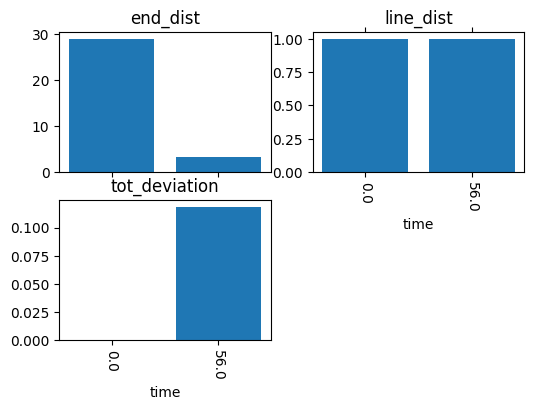

In [34]:
comp.as_plots(cols=2)